# Importing required libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

2023-08-03 13:47:52.480639: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-03 13:47:52.521658: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-03 13:47:52.522586: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-03 13:47:53.319404: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Preprocessing

In [2]:
# Reading csv file
df = pd.read_csv('training_data/letras_musicas.csv')
df.head()

,Título,Letra
0,'03 Bonnie & Clyde (feat. Jay-Z),"\nUhh, uhh, uhh\nYou ready, B?\nLet's go get ..."
1,1+1,\nIf I ain't got nothing\nI got you\nIf I ain...
2,6 Inch (feat. The Weeknd),\n[Beyoncé]\nSix inch heels\nShe walked in th...
3,632-5792,\n(Hello) hello\nHow are you (oh)\nI just got...
4,7/11,"\nShoulders sideways, smack it, smack it in t..."


In [3]:
df = df[['Letra']]


# Função para quebrar o texto e adicionar novas linhas ao DataFrame
def quebrar_e_adicionar_linhas(row):
    textos_quebrados = row['Letra'].splitlines()
    return pd.DataFrame({'Letra': textos_quebrados})

# Aplicar a função para cada linha do DataFrame e combinar os resultados
novo_df = pd.concat([quebrar_e_adicionar_linhas(row) for _, row in df.iterrows()], ignore_index=True)

In [4]:
novo_df

,Letra
0,
1,"Uhh, uhh, uhh"
2,"You ready, B?"
3,Let's go get 'em
4,Look for me!
...,...
25779,Você realmente quer viver eternamente?
25780,Eternamente jovem
25781,"Eternamente jovem, eu quero ser eternamente jo..."
25782,Você realmente quer viver eternamente?


In [5]:
novo_df.columns =  ['lyric']

In [6]:
# corpus will contain data that'll be converted to number sequences. 
corpus = novo_df['lyric'].tolist()
corpus[0:2]

[' ', 'Uhh, uhh, uhh']

In [7]:
# tokenizer will contain key value index to every word
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# will be used during prediction
reverse_word_index = dict(map(reversed, tokenizer.word_index.items()))

print('Total Words - ',total_words)
print("key of word 'around' is ",tokenizer.word_index['around'])
print("key of id '117' is ",reverse_word_index[117])

Total Words -  7948
key of word 'around' is  109
key of id '117' is  more


In [8]:
# Converting input to a sequence of number
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label where label is just the last value of every input_sequence
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

print(xs[10])
print(np.argmax(ys[100]))

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0 314 271]
159


## Creating LSTM Model and fitting data on it!

In [9]:

model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
# model.add(Bidirectional(LSTM(256,return_sequences= True)))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
print (model.summary())
history = model.fit(xs, ys, epochs=100, verbose=1)

2023-08-03 13:47:55.763708: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-08-03 13:47:55.763792: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: kunumi-Inspiron-5590
2023-08-03 13:47:55.763802: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: kunumi-Inspiron-5590
2023-08-03 13:47:55.763911: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 470.199.2
2023-08-03 13:47:55.763937: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 470.199.2
2023-08-03 13:47:55.763945: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 470.199.2


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 100)           794800    
                                                                 
 bidirectional (Bidirection  (None, 300)               301200    
 al)                                                             
                                                                 
 dense (Dense)               (None, 7948)              2392348   
                                                                 
Total params: 3488348 (13.31 MB)
Trainable params: 3488348 (13.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/100


2023-08-03 13:47:57.639165: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4347556000 exceeds 10% of free system memory.


4274/4274 [==============================] - 565s 132ms/step - loss: 5.7323 - accuracy: 0.0974
Epoch 2/100
 316/4274 [=>............................] - ETA: 8:39 - loss: 4.7773 - accuracy: 0.1808

KeyboardInterrupt: 

## Plotting accuracy over epoch

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

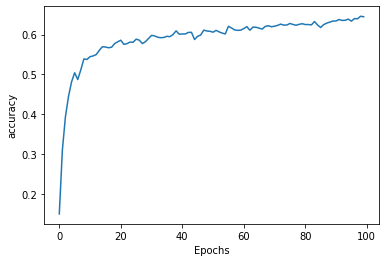

In [ ]:
plot_graphs(history, 'accuracy')

## Finally Saving Tokenizer and Trained Model !

In [ ]:
import pickle

with open('model_files/tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

model.save('model_files/lyrics_model.h5')